In [2]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

In [3]:
rSeed = 66

os.environ['PYTHONHASHSEED'] = str(rSeed)
np.random.seed(rSeed)
tf.random.set_seed(rSeed)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
DataDir = '../dataset/Fish_Dataset/Fish_Dataset'
os.listdir(DataDir)

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'license.txt',
 'README.txt',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Segmentation_example_script.m',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [6]:
clear_output()

In [7]:
import cv2
import imgaug.augmenters as iaa
import imgaug as ia
from tqdm import tqdm

ia.seed(rSeed)

In [8]:
IMG_SIZE = 224
ColorCh = 3

CATEGORIES = []
for list_ in os.listdir(DataDir):
    if not '.' in list_:
        CATEGORIES.append(list_)

print(CATEGORIES)

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


In [9]:
import random
random.seed(rSeed)

def prepareData(Dir, split_ratio):
    X = []
    y = []
    Frame = []
    
    flip = iaa.Fliplr(1.0)
    zoom = iaa.Affine(scale=1)
    random_brightness = iaa.Multiply((1, 1.2))
    rotate = iaa.Affine(rotate=(-20, 20))
    
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(Dir, category, (category))        
        if not os.path.isdir(path):
            pass
        
        else:
            class_num = CATEGORIES.index(category)
            limit = 1000
            img_list = os.listdir(path)[0:limit]
            random.shuffle(img_list)
            
            for img in tqdm(img_list):
                orig_img = cv2.imread(os.path.join(path,img) , cv2.IMREAD_COLOR)
                image_aug = cv2.resize(orig_img, (IMG_SIZE, IMG_SIZE), 
                                       interpolation = cv2.INTER_CUBIC)

                image_aug = flip(image = image_aug)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                image_aug = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                X.append(image_aug)
                y.append(class_num)
 
    if len(X) > 0:
        train_len = int(len(X) * split_ratio[0])
        valid_len = int(len(X) * split_ratio[1])
        test_len = int(len(X) * split_ratio[2])
        
        features = pd.DataFrame((np.array(X)).reshape(-1, IMG_SIZE * IMG_SIZE * ColorCh))
        labels = pd.DataFrame({'label': y})
        
        Frame = pd.concat([features, labels], axis=1).sample(frac = 1, random_state = rSeed)     
        train_df, valid_df, test_df = Frame[:train_len], Frame[train_len:train_len+valid_len], Frame[train_len+valid_len:train_len+valid_len+test_len]
        
        return train_df, valid_df, test_df

In [10]:
train_df, valid_df, test_df = prepareData(DataDir, split_ratio=[0.6, 0.2, 0.2])

 34%|███▎      | 337/1000 [00:02<00:03, 166.50it/s]


KeyboardInterrupt: 

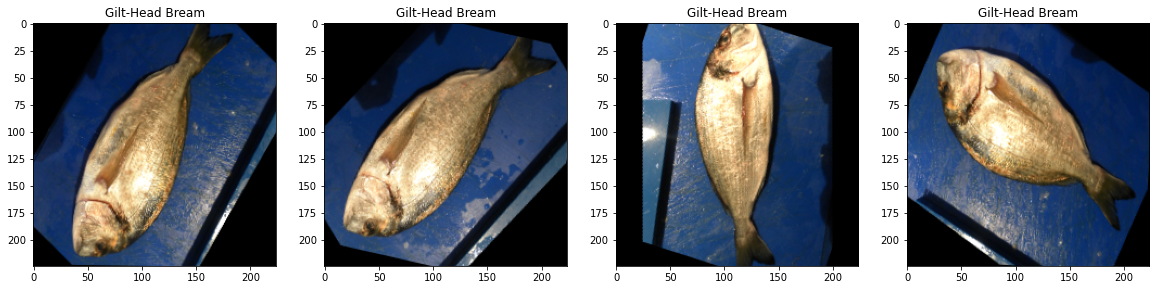

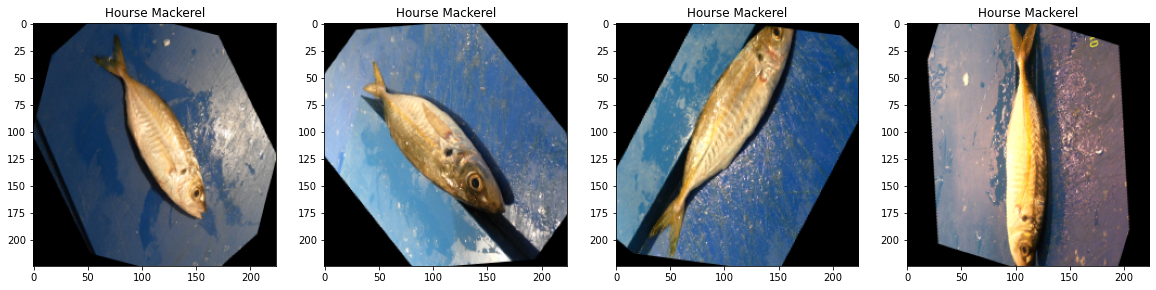

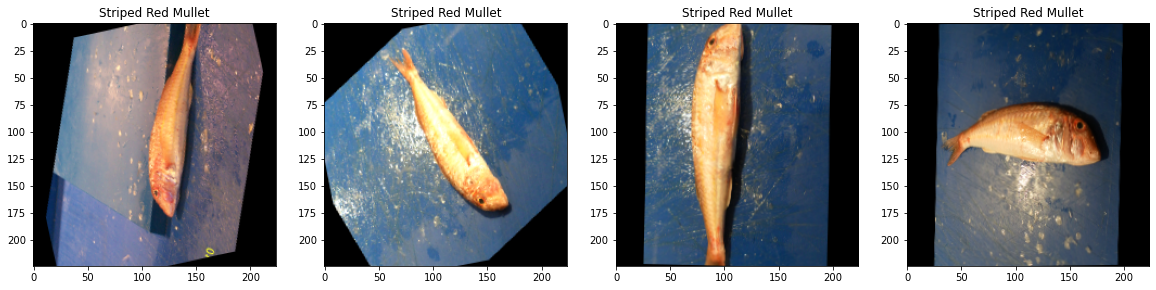

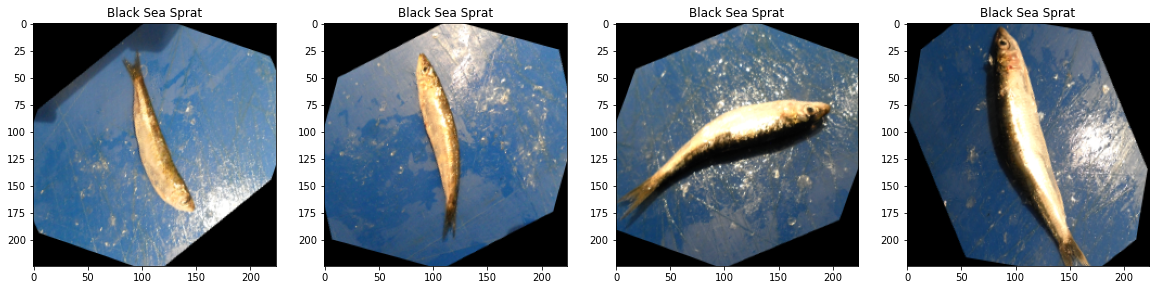

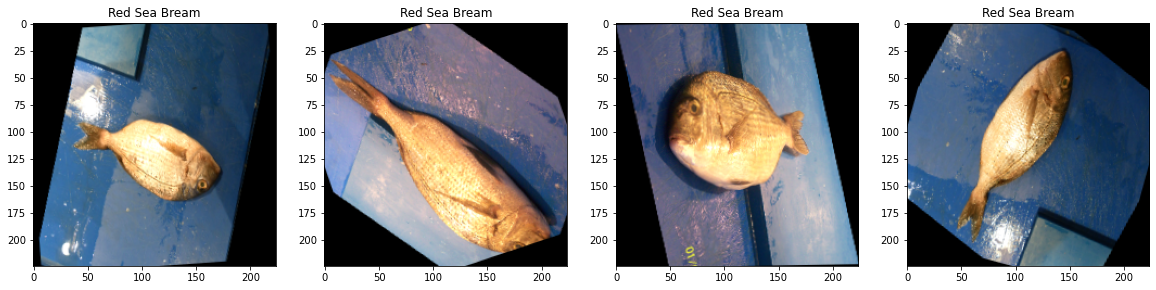

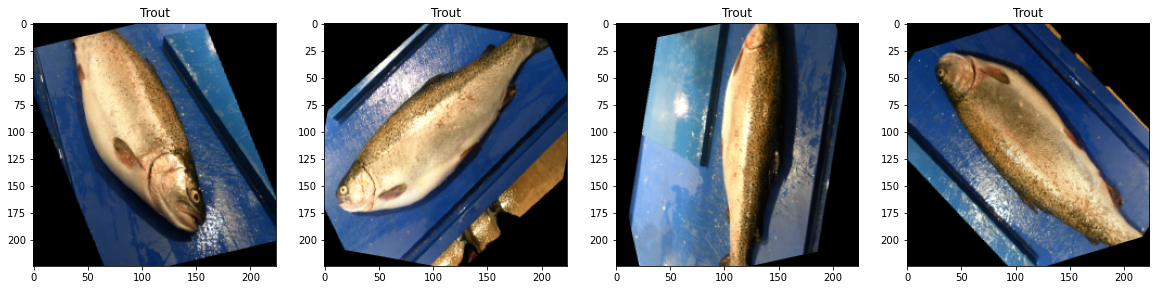

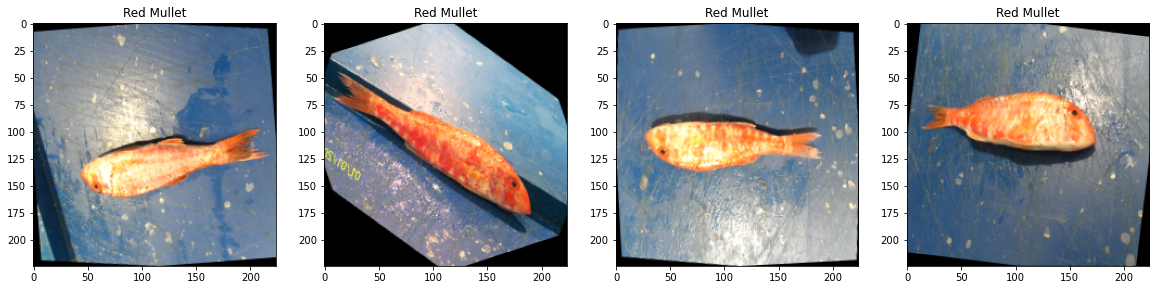

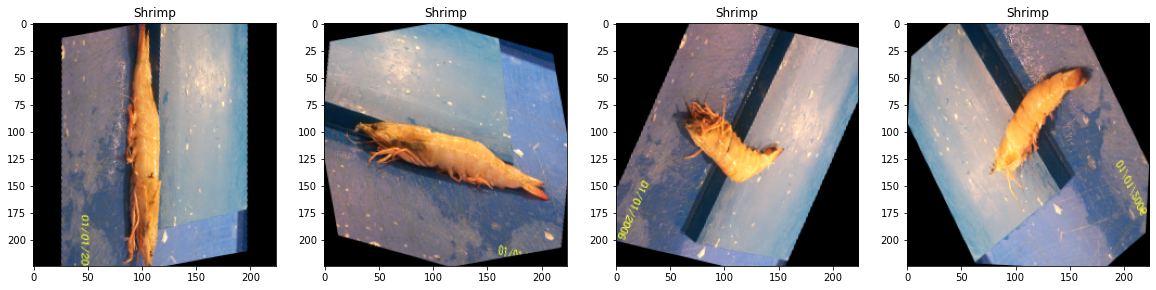

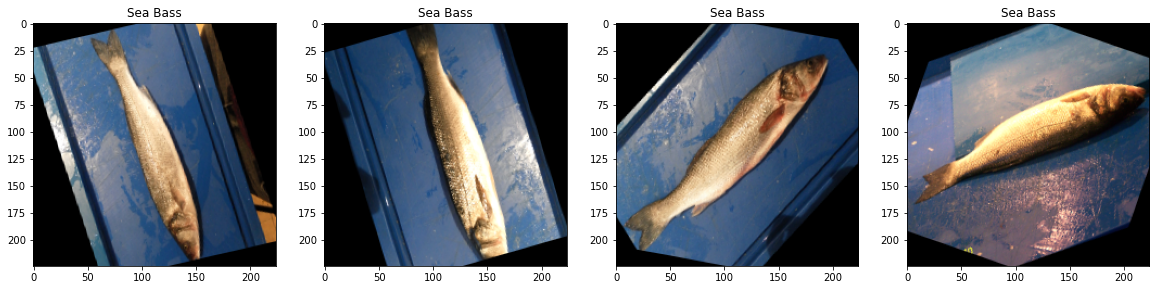

In [10]:
import matplotlib.pyplot as plt

def print_images(samples):
    images = samples.drop(["label"],axis = 1).to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image in enumerate(images):
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(CATEGORIES[labels[i]])
        Sample_image = image.reshape(IMG_SIZE, IMG_SIZE, ColorCh)
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
label_count = pd.Series(test_df['label'].values.ravel()).value_counts()
for label in list(label_count.index.values):
    samples = (test_df[test_df['label']==int(label)].iloc[0:4])
    print_images(samples)

%matplotlib inline

In [11]:
print('> DataFrame shape: ',train_df.shape)
print('> {} image data '.format(train_df.shape[0]))
print('> {} --> ({} * {} * {}) pixels + 1 label for each image (1d scaled)\n'.format(train_df.shape[1], IMG_SIZE,IMG_SIZE, ColorCh))

label_count_train = pd.Series(train_df['label'].values.ravel()).value_counts()
n_classes = len(label_count_train)
print('> Total Classes: {}'.format(n_classes))

> DataFrame shape:  (5400, 150529)
> 5400 image data 
> 150529 --> (224 * 224 * 3) pixels + 1 label for each image (1d scaled)

> Total Classes: 9


In [12]:
print('> label count for train')
label_count_train = pd.Series(train_df['label'].values.ravel()).value_counts()
for i in range(len(label_count_train)):
    print('> {} : {}'.format(CATEGORIES[i], label_count_train[i]))

> label count for train
> Black Sea Sprat : 602
> Gilt-Head Bream : 572
> Hourse Mackerel : 583
> Red Mullet : 607
> Red Sea Bream : 598
> Sea Bass : 607
> Shrimp : 609
> Striped Red Mullet : 604
> Trout : 618


In [13]:
print('> label count for valid')
label_count_valid = pd.Series(valid_df['label'].values.ravel()).value_counts()
for i in range(len(label_count_valid)):
    print('> {} : {}'.format(CATEGORIES[i], label_count_valid[i]))

> label count for valid
> Black Sea Sprat : 191
> Gilt-Head Bream : 205
> Hourse Mackerel : 209
> Red Mullet : 203
> Red Sea Bream : 206
> Sea Bass : 206
> Shrimp : 202
> Striped Red Mullet : 189
> Trout : 189


In [14]:
print('> label count for test')
label_count_test = pd.Series(test_df['label'].values.ravel()).value_counts()
for i in range(len(label_count_test)):
    print('> {} : {}'.format(CATEGORIES[i], label_count_test[i]))

> label count for test
> Black Sea Sprat : 207
> Gilt-Head Bream : 223
> Hourse Mackerel : 208
> Red Mullet : 190
> Red Sea Bream : 196
> Sea Bass : 187
> Shrimp : 189
> Striped Red Mullet : 207
> Trout : 193


In [15]:
X_train = train_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_train = train_df['label']

X_valid = valid_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_valid = valid_df['label']

X_test = test_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_test = test_df['label']

In [16]:
# data summary
print('> {} train images'.format(X_train.shape[0]))
print('> {} valid images'.format(X_valid.shape[0]))
print('> {} test images'.format(X_test.shape[0]))

input_shape = X_train.shape[1:]
print('> input shape:', input_shape)

> 5400 train images
> 1800 valid images
> 1800 test images
> input shape: (224, 224, 3)


In [17]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import activations
from keras import regularizers

In [18]:
kernel_regularizer = regularizers.l2(0.0001)
final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'

In [19]:
def vgg_block(num_convs, num_channels):
    block = tf.keras.models.Sequential()
    for _ in range(num_convs):
        block.add(Conv2D(filters=num_channels, kernel_size = (3,3), padding="same"))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        
    block.add(MaxPooling2D(pool_size=2, strides=2))
    return block

def VGG_MODEL(n_layers):
    supported_layers = [11, 13, 16, 19]
    
    if not n_layers in supported_layers:
        print('not supported')
        return
    
    if n_layers == 11:
        conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

    if n_layers == 13:
        conv_arch = ((2, 64), (2, 128), (2, 256), (2, 512), (2, 512))
        
    if n_layers == 16:
        conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
    
    if n_layers == 19:
        conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))
    
    
    vgg_model = Sequential()
    vgg_model.add(Input(shape=input_shape))
    
    for (num_convs, num_channels) in conv_arch:
        vgg_model.add(vgg_block(num_convs, num_channels))
    
    vgg_model.add(Flatten())
    
    vgg_model.add(Dense(units=4096))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Activation('relu'))
    vgg_model.add(Dropout(0.5, seed=73))
    
    vgg_model.add(Dense(units=4096))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Activation('relu'))
    vgg_model.add(Dropout(0.5, seed=73))
    
    vgg_model.add(Dense(units=n_classes, activation=final_activation))
    
    return vgg_model

In [20]:
def print_graph(item, index, history):
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    valid_values = history.history['val_' + item][0:index]
    plt.plot(valid_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()


def get_best_epoch(val_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(val_loss, 2) == round(arr[i], 2):
                    return i
        

def model_summary(model, history):
    print('---'*30)
    val_loss, val_accuracy = model.evaluate(X_valid, y_valid, verbose=0)

    if history:
        index = get_best_epoch(val_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on valid:',val_accuracy,'\tLoss on valid:',val_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

In [25]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 50
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 16 #64 will cause crash by KLC



rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

    
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.95) | (logs.get('loss') <= 0.05)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

            
            
end_callback = myCallback()

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


checkpoint_filepath = 'Fish_Weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

import datetime
log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

In [26]:
def CompileModel(model):
    model.summary()
    model.compile(optimizer='adam', loss=entropy,metrics=['accuracy'])
    return model


def FitModel(model, name):

    history = model.fit(X_train,y_train,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              batch_size = batch_size,
                              validation_data = (X_valid, y_valid)
                              )
    
    model.load_weights(checkpoint_filepath)

    final_accuracy_avg = np.mean(history.history["val_accuracy"][-5:])

    final_loss = history.history["val_loss"][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss:'loss'}

    clear_output()
    model.summary()

    print('\n')
    print('---'*30)
    print(name,' Model')
    print('Total Epochs :', len(history.history['loss']))
    print('Accuracy on train:',history.history['accuracy'][-1],'\tLoss on train:',history.history['loss'][-1])
    print('Accuracy on val:', final_accuracy_avg ,'\tLoss on val:', final_loss)
    print('---'*30)

    return model, history

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 112, 112, 64)      39232     
_________________________________________________________________
sequential_8 (Sequential)    (None, 56, 56, 128)       222464    
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28, 256)       1478400   
_________________________________________________________________
sequential_10 (Sequential)   (None, 14, 14, 512)       5905920   
_________________________________________________________________
sequential_11 (Sequential)   (None, 7, 7, 512)         7085568   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)             

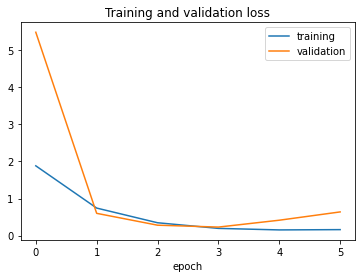

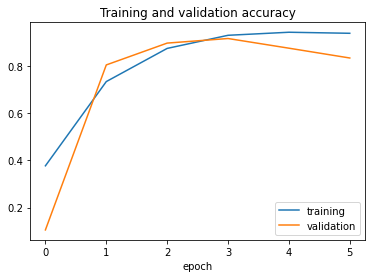

------------------------------------------------------------------------------------------


In [27]:
skip_training = False

mode = 'proMode'

def BuildModel():
    prepared_model = VGG_MODEL(16)
    compiled_model = CompileModel(prepared_model)

    return compiled_model

compiled_model = BuildModel()
model, history = FitModel(compiled_model, 'vgg')
model_summary(model, history)

In [28]:
model.save('DEMO.h5')

In [29]:
import seaborn as sns
from sklearn import metrics

def test_set_results(pred_value, X, y):    
    corr_pred = metrics.confusion_matrix(y, pred_value)
    
    fig=plt.figure(figsize=(10, 8))
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
    plt.show()
    

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def printResults(model, X, y):  
    predictions = model.predict(X, batch_size=4)
    pred = np.argmax(predictions, axis=1)
    pred = [CATEGORIES[k] for k in pred]
    
    target_names = ['negative','positive']
    print(classification_report(y, predictions.argmax(axis=1), target_names=CATEGORIES))
    test_set_results(predictions.argmax(axis=1), X, y)

In [31]:
def eval_model(model, X, y, name):
    test_loss, test_accuracy = model.evaluate(X, y, verbose=0)
    print('Final Accuracy on {}:'.format(name),test_accuracy,'\tLoss on {}:'.format(name),test_loss)
    print('---'*30)


loading at DEMO.h5
------------------------------------------------------------------------------------------
Final Accuracy on train: 0.9800000190734863 	Loss on train: 0.059527039527893066
------------------------------------------------------------------------------------------
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.96      0.98       602
   Gilt-Head Bream       0.96      1.00      0.98       572
   Hourse Mackerel       1.00      0.99      0.99       583
        Red Mullet       0.91      1.00      0.96       607
     Red Sea Bream       0.99      0.96      0.98       598
          Sea Bass       0.98      0.99      0.98       607
            Shrimp       1.00      0.98      0.99       609
Striped Red Mullet       0.99      0.95      0.97       604
             Trout       0.99      1.00      0.99       618

          accuracy                           0.98      5400
         macro avg       0.98      0.98      0.98      

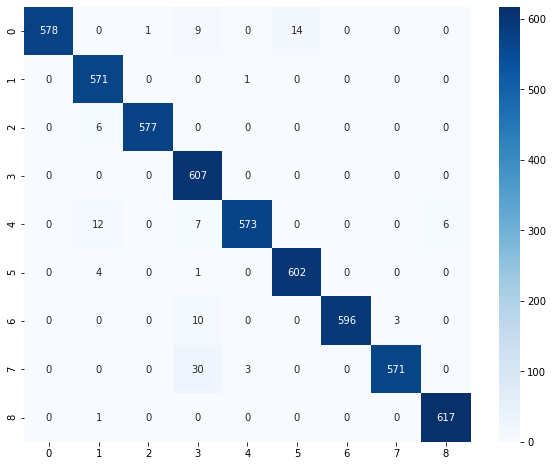

In [33]:
path = 'DEMO.h5'
print('\nloading at {}'.format(path))

if os.path.exists(path):
    model = tf.keras.models.load_model(path)
    print('---'*30)
    eval_model(model, X_train, y_train, 'train')
    printResults(model, X_train, y_train)

------------------------------------------------------------------------------------------
Final Accuracy on valid: 0.949999988079071 	Loss on valid: 0.14218436181545258
------------------------------------------------------------------------------------------
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.94      0.97       191
   Gilt-Head Bream       0.88      1.00      0.93       205
   Hourse Mackerel       1.00      0.97      0.98       209
        Red Mullet       0.82      1.00      0.90       203
     Red Sea Bream       0.98      0.89      0.94       206
          Sea Bass       0.96      0.93      0.95       206
            Shrimp       1.00      0.97      0.98       202
Striped Red Mullet       0.98      0.86      0.92       189
             Trout       0.98      0.99      0.99       189

          accuracy                           0.95      1800
         macro avg       0.96      0.95      0.95      1800
      weighted av

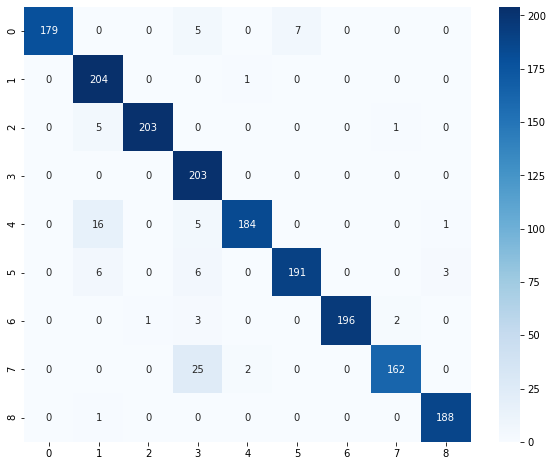

In [34]:
if os.path.exists(path):
    model = tf.keras.models.load_model(path)
    print('---'*30)
    eval_model(model, X_valid, y_valid, 'valid')
    printResults(model, X_valid, y_valid)

------------------------------------------------------------------------------------------
Final Accuracy on test: 0.9549999833106995 	Loss on test: 0.1278848499059677
------------------------------------------------------------------------------------------
                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      0.90      0.95       207
   Gilt-Head Bream       0.93      0.99      0.96       223
   Hourse Mackerel       1.00      0.99      0.99       208
        Red Mullet       0.84      1.00      0.91       190
     Red Sea Bream       0.99      0.93      0.96       196
          Sea Bass       0.95      0.96      0.95       187
            Shrimp       1.00      0.94      0.97       189
Striped Red Mullet       0.96      0.90      0.93       207
             Trout       0.97      0.99      0.98       193

          accuracy                           0.95      1800
         macro avg       0.96      0.96      0.96      1800
      weighted avg 

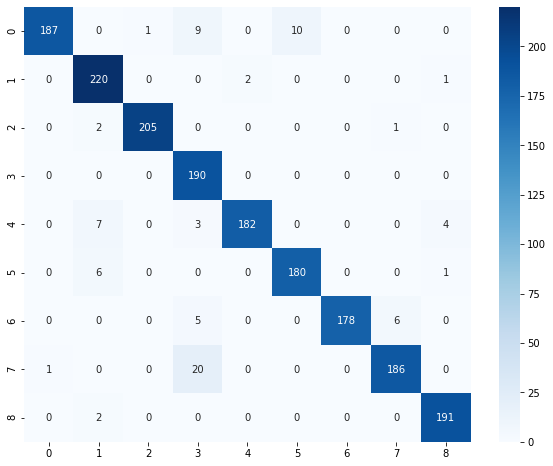

In [35]:
if os.path.exists(path):
    model = tf.keras.models.load_model(path)
    print('---'*30)
    eval_model(model, X_test, y_test, 'test')
    printResults(model, X_test, y_test)